In [16]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow.keras.callbacks import TensorBoard

In [17]:
from sentence_transformers import SentenceTransformer

# Replace 'sentence-transformers/bert-base-nli-mean-tokens' with your desired model name
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df2 = pd.read_parquet('clean_data.pqt')

In [21]:
df = df2.sample(4000)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
113768,6060b8a94a2e6b4d,hi editors might see differently right certain...,0,0,0,0,0,0
52747,8cffe3de4a0cc179,unblocking avowed racist member kkk de facto r...,0,0,0,0,0,0
17117,2d2349b1e008898f,population control measures,0,0,0,0,0,0
63611,aa32f471e48c91a7,throw jew well country free,0,0,0,0,0,1
27999,4a16e2a53c4f00be,e robinson 1838 calls copious stream whatever ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
85501,e4b32922ce502a95,thought rjensen sockpuppets never showed talk ...,0,0,1,0,1,0
90683,f2a01b94d21c3bc9,redirect user talk veggies archive 2,0,0,0,0,0,0
115702,6ac4edd24b0c69a2,please read wp copyrights information policies...,0,0,0,0,0,0
10198,1afe31fa53016a70,addition please note constitutes deliberate in...,0,0,0,0,0,0


In [22]:
embeddings= model.encode(df['comment_text'].tolist())
df['emb'] = embeddings.tolist()

In [23]:
embeddings.shape

(4000, 768)

In [24]:
max_len = df['emb'].apply(len).max()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
sequences = np.array(df['emb'].tolist())
sequences = sequences.reshape(4000, 1, 768)
print("Shape of sequences before reshaping:", sequences.shape)

Shape of sequences before reshaping: (4000, 1, 768)


In [26]:
max_words = 1300  # Number of embeddings per sample
dmsn = 768     # Dimensionality of each embedding


In [27]:


padded_sequences = pad_sequences(sequences, maxlen=max_words, padding='post', truncating='post')


In [28]:
X = np.array(padded_sequences)
y = df.drop(['id','comment_text', 'emb'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

In [29]:
X_train.shape

(2800, 1300, 768)

In [30]:
# dmsn = len(df['emb'].iloc[0])

# print("Dimensionality of the embeddings:", dmsn)

In [31]:
# # Reshape X_train and X_test to fit the RNN
# X_train = X_train.reshape(X_train.shape[0], max_words, dmsn)
# X_test = X_test.reshape(X_test.shape[0], max_words, dmsn)

In [32]:
def history_plots(redux, metric):
    valid = "val_"+metric
    plt.plot(redux.history[metric], label=metric)
    plt.plot(redux.history[valid], label=valid)
    plt.legend()
    plt.show()

In [33]:
filename= "ST_LSTM"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

i = Input(shape=(max_words, dmsn))
x = LSTM(128)(i)
x = Dense(64, activation='relu')(x)
x = Dense(6, activation='softmax')(x)
lstm_model2 = Model(i, x) 


In [35]:
lstm_model2.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=.000025), metrics=['accuracy', Recall(name= 'recall'), Precision(name='precision')])
r =lstm_model2.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_test, y_test),callbacks=[tb])

Epoch 1/10
70/70 [==============================] - 30s 217ms/step - loss: 0.3993 - accuracy: 0.9236 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3180 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
70/70 [==============================] - 17s 249ms/step - loss: 0.3993 - accuracy: 0.9943 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3180 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
70/70 [==============================] - 22s 324ms/step - loss: 0.3993 - accuracy: 0.9943 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3180 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
70/70 [==============================] - 22s 313ms/step - loss: 0.3992 - accuracy: 0.9943 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3180 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/10
70/70 [==================

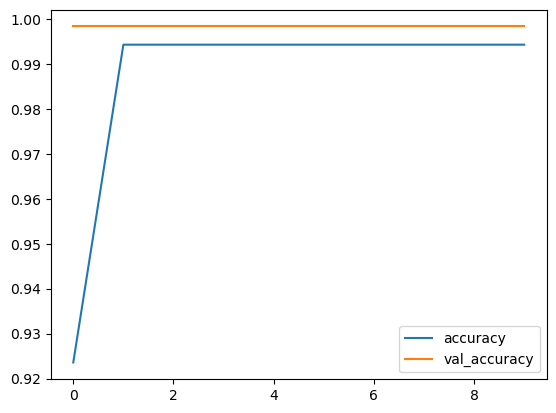

In [36]:
history_plots(r,'accuracy')

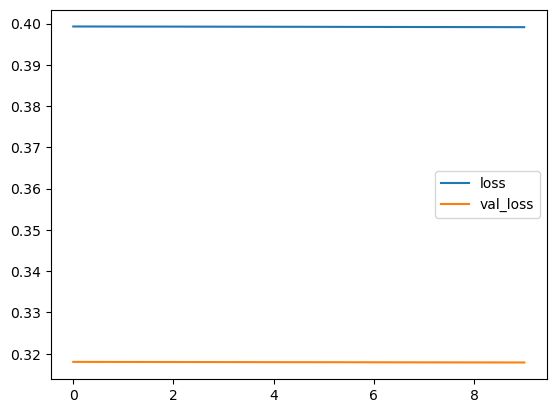

In [37]:
history_plots(r,'loss')

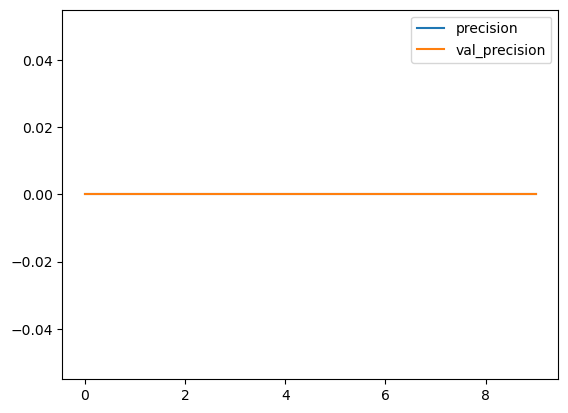

In [38]:
history_plots(r,'precision')

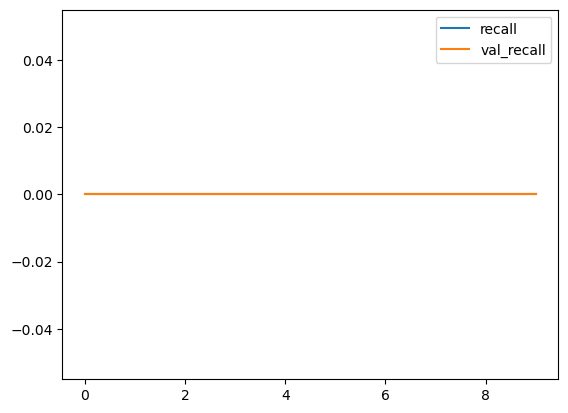

In [39]:
history_plots(r,'recall')

In [40]:
def f1_derive(hist=r,prc='precision',rcl='recall'):
    vp= 'val_'+prc
    v_re= 'val_'+rcl
    CH_hist= pd.DataFrame(hist.history)
    CH_hist['f1'] =(2*CH_hist[prc]*CH_hist[rcl])/(CH_hist[prc]+CH_hist[rcl])
    CH_hist['val_f1'] =(2*CH_hist[vp]*CH_hist[vp])/(CH_hist[vp]+CH_hist[vp])
    CH_hist.fillna(0,inplace=True)

    plt.plot(CH_hist['f1'], label='f1')
    plt.plot(CH_hist['val_f1'], label='val_f1')
    plt.legend()
    plt.show()

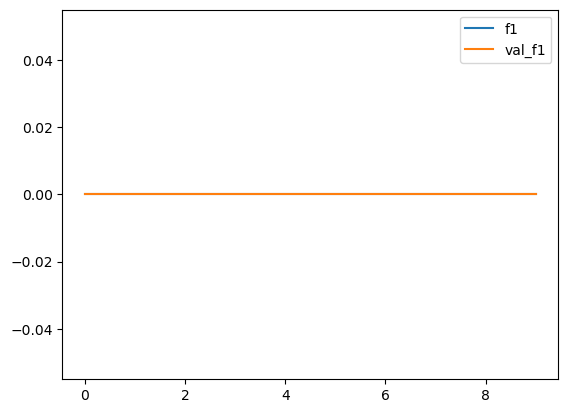

In [41]:
f1_derive()

In [42]:
filename= "ST_CNN"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten

i = Input(shape=(max_words, dmsn))

# Conv1D layer
x = Conv1D(32, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)

# Flatten layer
x = Flatten()(x)

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

# Create the Model
cnn_model = Model(i,x)


In [44]:
cnn_model.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=.000025), metrics=['accuracy', Recall(name= 'recall'), Precision(name='precision')])
g=cnn_model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_test, y_test),callbacks=[tb])

Epoch 1/10
70/70 [==============================] - 19s 153ms/step - loss: 0.3956 - accuracy: 0.6818 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3097 - val_accuracy: 0.9942 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
70/70 [==============================] - 8s 120ms/step - loss: 0.3763 - accuracy: 0.9939 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2867 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
70/70 [==============================] - 16s 226ms/step - loss: 0.3500 - accuracy: 0.9943 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2701 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
70/70 [==============================] - 13s 189ms/step - loss: 0.3388 - accuracy: 0.9943 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2627 - val_accuracy: 0.9983 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/10
70/70 [===================

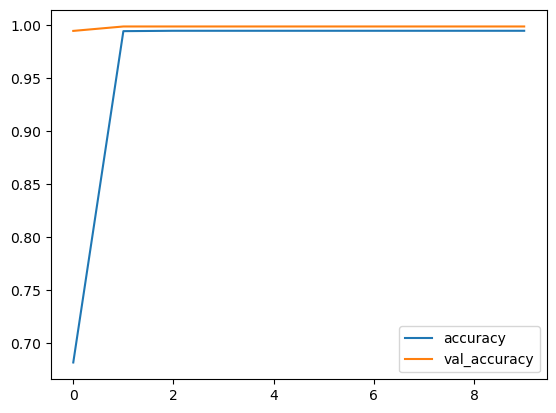

In [45]:
history_plots(g,'accuracy')

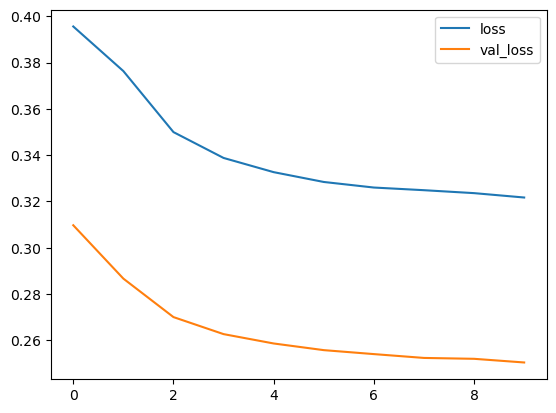

In [46]:
history_plots(g,'loss')

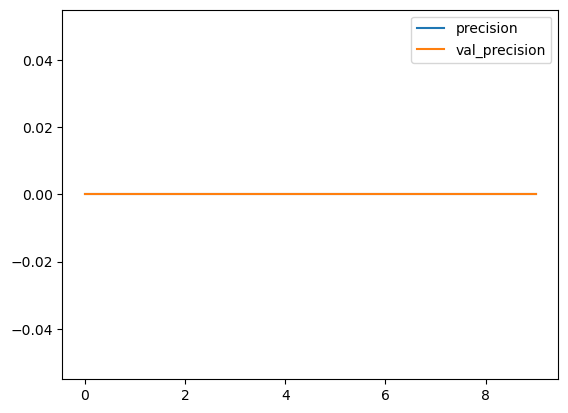

In [47]:
history_plots(g, 'precision')

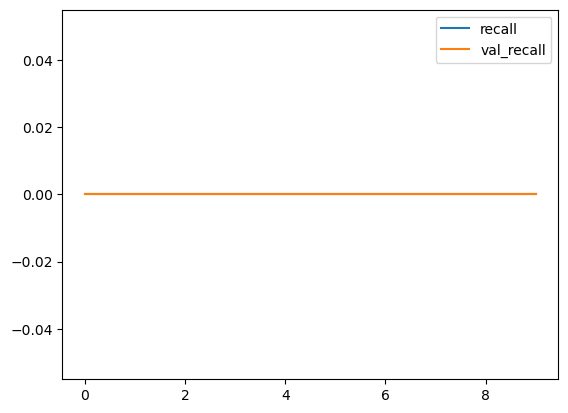

In [48]:
history_plots(g,'recall')

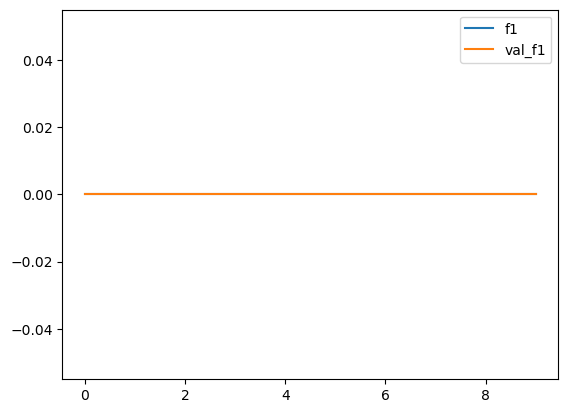

In [49]:
f1_derive(g)